In [59]:
import numpy as np
import matplotlib.pyplot as plt
import geometries as gm
import solver as sv
from importlib import reload
reload(gm);
reload(sv);

In [63]:
fp = lambda s: s[::-1]

# Part 1: Introduction to the problem
## The problem
- Find the **optimal path and speeds** of a race car to complete a race track in **minimum time**.
- When driving around curves, the car must slow to avoid losing traction.
- The car has limited acceleration and braking ability (e.g cannot go from 50km/h to 250km/h in one second!).
- The car must stay on the pavement.
- Full knowledge of the track ahead is assumed





### Illustration of under-steering 
    

![Understeer](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f7/Understeer-right-hand-drive.svg/200px-Understeer-right-hand-drive.svg.png)

    

source: [wikipedia](https://commons.wikimedia.org/wiki/File:Understeer-right-hand-drive.svg)





## Principle of optimal path
- Tight curves are slow, so the driver should try to smooth them by starting to turn before the bend in the road, and ending the turn after the bend (path 2 below)

- Use the maximum possible speed for each segment.

![bend](https://s3-us-west-2.amazonaws.com/courses-images-archive-read-only/wp-content/uploads/sites/222/2014/12/20102654/Figure_07_03_04a-350x474.jpg)

In [75]:
def draw_track_examples():
    fig, ax = plt.subplots(1,2, figsize=(20,8))

    tr = gm.compose_track(gm.turtlehead)
    gm.plot_segments(tr.segments,20,color='k-', ax=ax[0], show=False)
    tr = gm.compose_track(gm.lionhead)
    gm.plot_segments(tr.segments,20,color='k-',ax=ax[1], show=False)
    ax[0].set_title('"בצ שאר"', fontsize=20)
    ax[1].set_title('"הירא שאר"',fontsize=20);
    ax[0].text(0,10,"start",fontsize=12)
    ax[0].text(70,-60,"finish",fontsize=12)
    ax[0].set_xlabel(fp("מטרים"),fontsize=14)
    ax[0].set_ylabel(fp("מטרים"),fontsize=14)
    ax[1].text(0,20,"start",fontsize=12)
    ax[1].text(300,-100,"finish",fontsize=12)
    ax[1].set_xlabel(fp("מטרים"),fontsize=14)
    ax[1].set_ylabel(fp("מטרים"),fontsize=14)


## Example tracks
- Each plot below shows a different track's centerline
- These tracks are made up, with reasonable scales and curves for use by "normal cars"

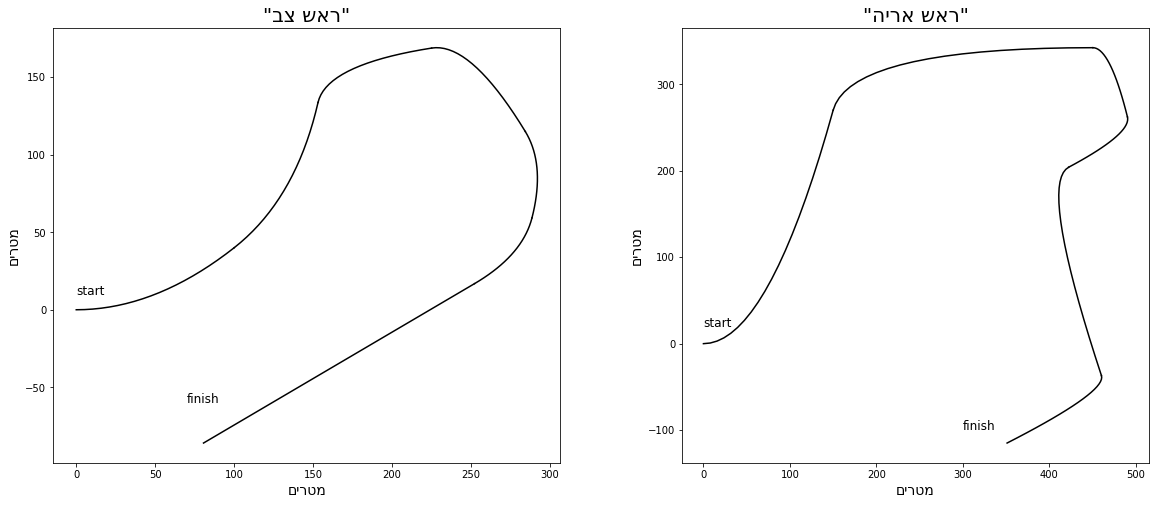

In [76]:
draw_track_examples()


## Example solution path
- The blue dotted line represents the car's path
- The deviations are exaggerated for illustration purposes
- As expected, the chosen path "smoothes" the turns

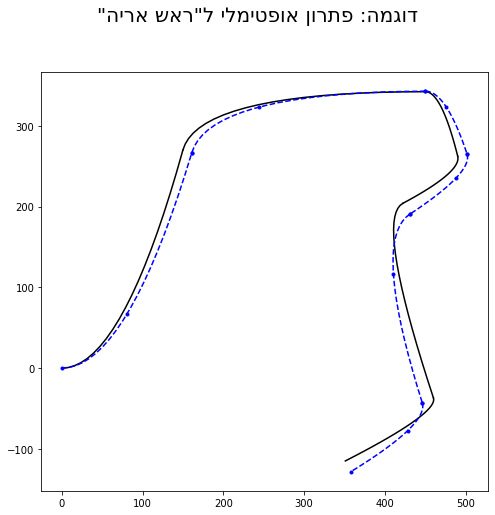

In [79]:
fig = plt.figure(figsize=(8,8))
fig.suptitle(fp('דוגמה: פתרון אופטימלי ל"ראש אריה"'),fontsize=20)
sv.test_solver()


# Part 2: Details of geometric representation
## Choosing piecewise parabolic segments as the main geometric representation 

The geometric representation allows to describe the geometric entities (track's shape, car path's shape), using  parameters. These parameters are needed to formulate the optimization problem.  

I use parabola segments. This is a simple representation, which can be made C1-continuous. It is useful for representing the track's centerline, as well as the car path's shape.

Recall that a parabola in the plane has 4 parameters. In analytical geometry, a parabola is defined by the (x,y) coordinates of the _focus_ and the 2 parameters describing the _directrix_ (a straight line). However if we "start" with the family of parabolas $y=ax^2$, by translation and rotation in the plane we can to obtain any parabola (i.e. any focal point and directrix). 

## Parametric representation of a parabolic segment
List of parameters:
- $a$, the parabola's curvature
- $(x_o,y_o)$, the amount of shift relative to the origin (offset)
- $\theta$, the amount of rotation.
- $s$, the "length" of the segment. More accurately, it is the maximum $x$ value (before shift and rotation). The minimum x value is always 0.

The parametric equations of the "basic" parabola are
$$x=mt\\y=as^2t^2\\0 \le t \le 1$$

The parametric equations with rotation and shift:
$$x=x_o + st\cos \theta - as^2t^2 \sin \theta\\
y=y_o + st \sin \theta + as^2t^2 \cos \theta$$






## C1 continuity conditions 
For a path composed piecewise of segments to be C1 continious, two conditions must hold:
- Each segment (except the first) should start at the end point of the previous
- The direction (derivative) of each segment, at its leftmost point, should math that of the previous, at its rightmost point.

Since the location and rotation in the plane of the track as a whole do not matter, we (arbitrarily) set the first path segment to rotation and translation 0. Each subsequent path's translation and rotation are determined by the two continuity equation relative to the one before. This means that **the two vectors $a=(a_1,\ldots a_N)$ and $m=(m_1,\ldots m_N)$ uniquely determine the path.**

The equations are as follows:
#### c0: 

$$x_{o(i)} + s_i\cos \theta_i - as_i^2 \sin \theta_i = x_{o(i+1)}\\
y_{o(i)} + s_i \sin \theta_i + as_i^2 \cos \theta_i = y_{o(i+1)}$$

### c1:
$$\theta_i + \tan^{-1}\frac{dy}{dx}|_{x=s_i} = \theta_{i+1}\\
\Downarrow\\
\theta_i + \tan^{-1}2a_is_i= \theta_{i+1}$$




# Part 3: Details of the problem formulation
## The decision variables
The decision variables should represent the speed of the car and the steering inputs along the path. I made the following design choices:
* The initial conditions of the car are predetermined. In other words, the car's speed, position and direction at the starting point of the track are known (and therefore not optimized). Note that the speed is not zero.
* The car will be assumed to have a constant accelaration (i.e. linear speed) and a constant steering angle (turn radius) within each track segment.
* The decision variables will represent deviations from a _nominal_ set of speeds and steering inputs.

Therefore, for a track of $N$ parabolic segments, a total of $2N$ variables are required to represent the turning and engine/brake decisions of the driver.


### Nominal solution 
A nominal solution is one that is "good enough" for the given track. 
It has the following qualities: 
* Can be calculated directly (without optimization)
* Feasible.

For the race track problem, the following approach yields a nominal solution:
* Set the car's path to the centerline of the track
* Calculate speeds based on the traction limit for the give path, and other considerations.

Once the nominal solution is obtained, the decision variables are defined _relative to the nominal_ as follows:
* The speed at each knot is $m_i(1+u_i)$ where $m_i$ is the nominal speed and $u_i$ is the decision variable.
* The lateral position of the car at the knot is $d_i$, where $d_i=0$ represents the car being positioned on the centerline, $d_i \gt 0$ is a deviation towards the left and $d_i \lt 0$ is a deviation towards the right.

Therefore, the zero vector represents the nominal solution.



### Details of physical considerations applied to the nominal solution
#### 1. Traction 
For each section of the track, there is an associated parameter &mu; which represents the traction (i.e. friction) between the track and tires. In our problem I assumed &mu; to be constant for all segments.

The speed of the car at the _beginning_ of each track segment, is bounded by $$\frac{m_i^2}{R_{i+1}} \le \mu$$.

The speed of the car at the _end_ of each track segment is bounded by $$\frac{m_i^2}{R_{i}} \le \mu \cdot g_s$$ 
- $R_{i}$ is the radius of curvature of the preceding track segment
- $g_s$ represents the additional grip of an accelarating car relative to a car traveling at constant speed.

1. The difference between two consecute speeds is bounded by an acceleration parameter $e$ and a braking parameter $b$ (together with the segment's length): $-2 \cdot b \cdot s_{i+1} \le m_{i+1}^2-m_i^2 \le 2 \cdot e \cdot s_{i+1}$
1. The speeds must be below the car's top speed: $m_i^2 \le V_{\max}^2$
1. All speeds are positive.

#### Algorithm for calculating the nominal solution
1. Set $R_i = \frac{2}{a_i}$. This is a zero-th order approximation around $x=0$, it is also "safe" since it is the lower bound for the curvature of a parabolic curve.
1. $m_i^2 \leftarrow \min\{\mu \cdot R_{i+1}, V_{\max} \}$
1. $m_i^2 \leftarrow \min\{m_i^2, m_{i+1}^2-2\cdot e \cdot s_{i+1}, m_{i-1}^2+2\cdot b \cdot s_{i}$
1. repeat step 3 until no change to any $m_i^2$
1. $m_i \leftarrow + \sqrt{m_i^2}



#### 
#### How it is used
When a problem is given, the code first calculates the nominal solution, i.e. a feasible set of speeds and deviations. Then, the 
AGood nominal solution is an easily-obtained solution guaranteed to be feasible. It represents a reasonable.
In this case, if the driver simply follows the track's centerline and keeps the car's speed below the traction limit, then he or she will be able to finish the race. This lead me to approach the problem in two stages:
* Nominal solution stage - directly calculate the nominal solution (no optimization algorithm required)
* Optimization stage - starting from the nominal solution, find an optimal solution.

My decision variables represents _deviations_ from the nominal value:
* The speed of the car at each knot is $m_i(1+u_i)$ where $m_i$ is the nominal speed and $u_i$ is the decision variable.
* The later position of the car as it crosses the boundary between two parabolic track segments is $d_i$, where $d_i=0$ represents the car being positioned on the centerline.
.

#### Details of the nominal solution
* 

### Convexity
This is a minimization problem, so in order for the problem to have a solution, the Objective Function must go to $+\infty$ when any of the parameters go to $\pm\infty$. Since steering left/right and accelaration/brake are (more or less) symmetric control inputs, I decided that the problem parameters would represent **deviations from a known solution**.

A nominal solution one that is "reasonable" but not necessarily optimal. It can be directly calculated from the problem parameters.

Additionally we want $x_0$, our initial guess, to be feasible.

It is also very helpful to have a feasible solution
I wanted the problem to be convex in all its parameters. 